# First Capstone: Analyzing Nice Ride data

[Nice Ride](https://www.niceridemn.com/) is Minneapolis' bike sharing program. A fleet of around 3,000 bikes are available seasonally, at stations located throughout the city. Users can become seasonal subscribers with 24/7 access, and both single-use and day pass options are available by paying via credit card at a Nice Ride station, or by using the Nice Ride mobile app.

[Nice Ride's data is publicly available](https://www.niceridemn.com/system-data), compiled monthly for the most recent biking season. Each "biking season" varies, but typically runs from April through November of a given year. (This is Minnesota, where winter riders are hardy, but few.)

Data for all previous seasons (2010 through the year before the current season's year) is compiled and made available per year.

__I chose the month of July, 2018 to analyze__--July is mid-season, so more trips will be available for analysis than would be available at either end of the season.

## What kind of data is available? 

The monthly data contains the following fields:
>* Trip Duration (seconds)
* Start Time and Date
* Stop Time and Date
* Start Station Name, ID (none if dockless ride)
* End Station Name, ID (none if dockless ride)
* Start and End Station Lat/Long (bike lat/long at start and end of rental if dockless ride)
* Bike ID
* User Type (Customer = Single ride or Day Pass; Subscriber = Annual or Monthly Member)
* Gender (Zero=unknown; 1=male; 2=female)
* Year of Birth<br><br>
>And rides have to last for at least 1 minute to be included in the Trip Data files.<br><br>
This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations at our warehouses and any trips lasting less than 60 seconds (potentially false starts or users trying to re-dock a bike to ensure it's secure).

## Issues I found with Nice Ride's data

* The trip duration column had some extreme outliers--the maximum value was equivalent to 125 days. I chose to apply a maximum duration of 24 hours to this column, and I use those filtered records for the rest of the analysis. I generate summary statistics before and after filtering, to show how those values are affected.
* There are a large number of records with a gender of 0/Unknown, and a birth year of 1969. I took these to be default values when the actual values are unknown. I filtered these records from the birth year graph.
* Similarly, when looking at gender, I created two pie charts, including and excluding records where gender is Unknown, to give a better picture of the split between males and females.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from datetime import datetime, time
%matplotlib inline

df = pd.read_csv('201807-niceride-tripdata.csv.zip')

## Which stations are the most popular for Nice Ride rentals?


### In general

The top 10 most frequent start and end stations are nearly identical--to be sure that they were in fact different, I examined the top 20 stations. Many of the same stations still appear on both lists, however not entirely in the same order.

In addition to the more obviously recreational stations (discussed in more detail below), I see a good mix of locations at the U of M, and in downtown Minneapolis. Downtown and the U both lie along the Mississippi River, so  they could be recreational rides, but it is more likely that they are commutes.

### Popular starting stations

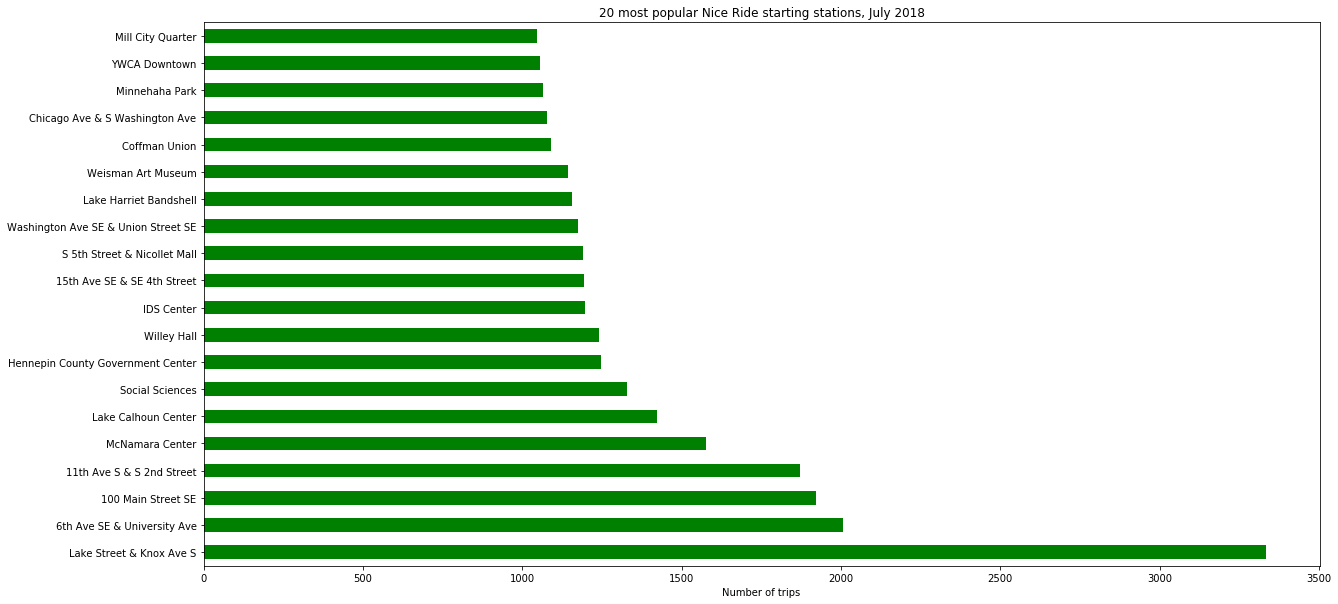

In [2]:
fig, ax_top20 = plt.subplots(figsize=(20,10))
top_20_start_stations = df['start station name'].value_counts()[:20]

ax_top20 = top_20_start_stations.plot.barh(color='Green')
ax_top20.set_title('20 most popular Nice Ride starting stations, July 2018')
ax_top20.set_xlabel('Number of trips')
plt.show()

### Popular end stations

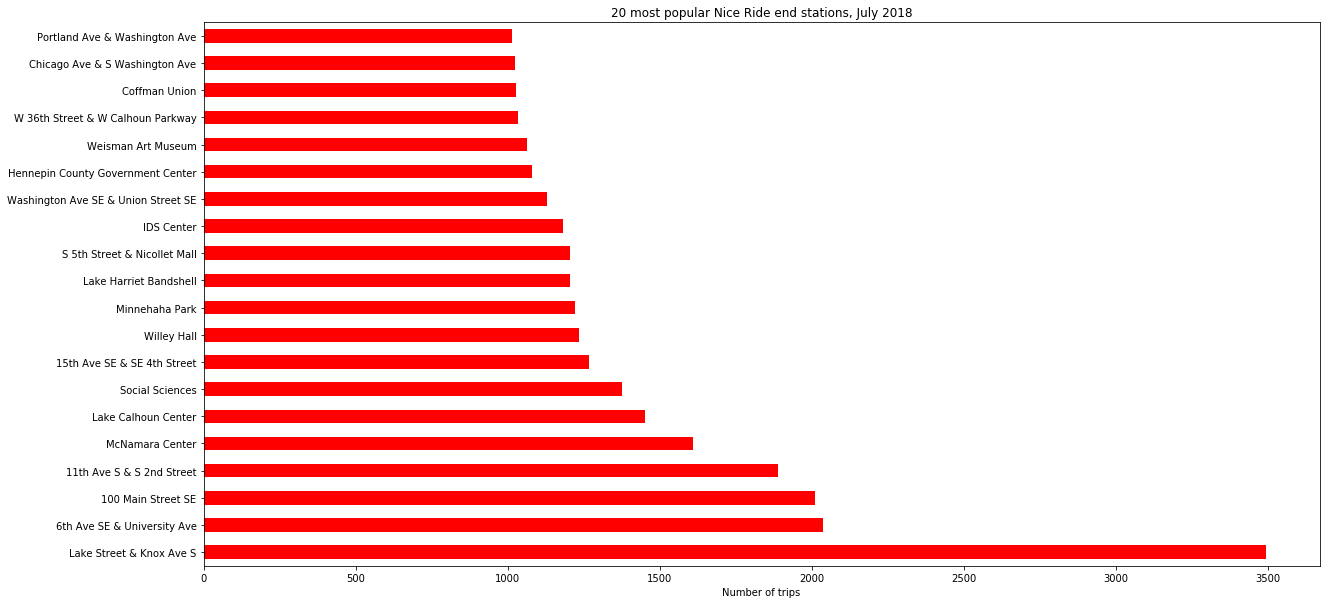

In [3]:
fig, ax_top20 = plt.subplots(figsize=(20,10))
top_20_end_stations = df['end station name'].value_counts()[:20]

ax_top20 = top_20_end_stations.plot.barh(color='Red')
ax_top20.set_title('20 most popular Nice Ride end stations, July 2018')
ax_top20.set_xlabel('Number of trips')
plt.show()

### Where start and end stations are the same

The nearly identical top 10 locations on the start and end point lists made me curious about the most popular stations where the start and end of a trip are the same. 

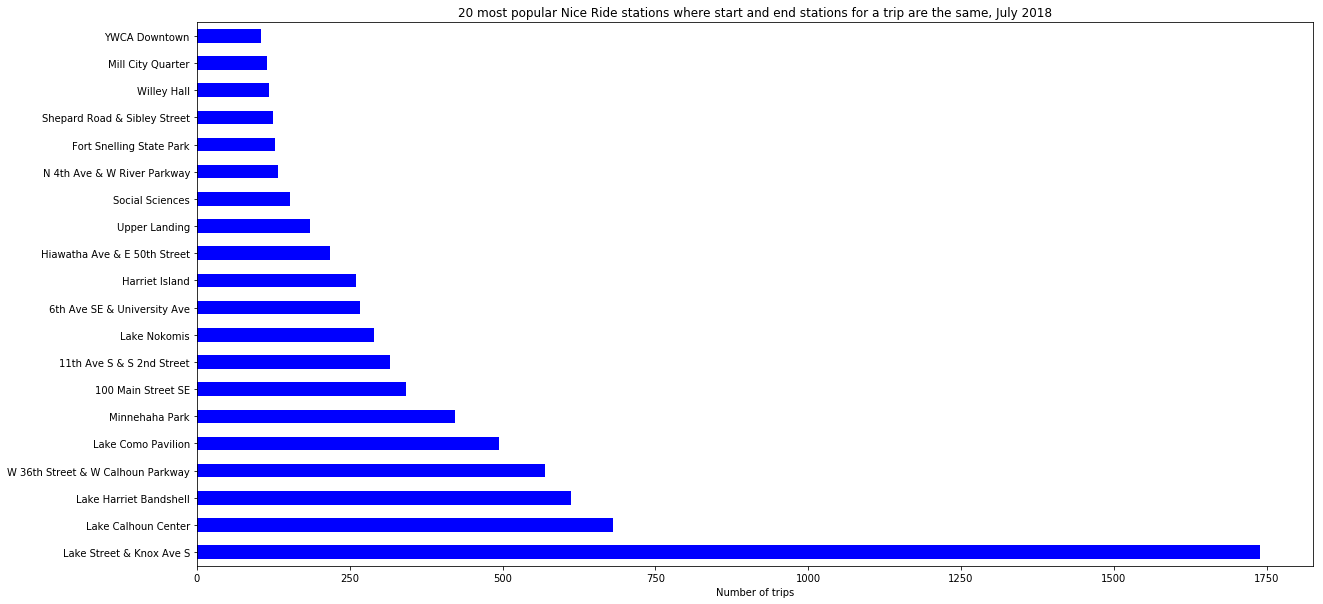

In [4]:
fig, ax_top20 = plt.subplots(figsize=(20,10))
df_loops = df.loc[(df['start station id'] == df['end station id'])]
top_20_loop_stations = df_loops['start station name'].value_counts()[:20]

ax_top20 = top_20_loop_stations.plot.barh(color='Blue')
ax_top20.set_title('20 most popular Nice Ride stations where start and end stations for a trip are the same, July 2018')
ax_top20.set_xlabel('Number of trips')
plt.show()

Based on the station names in this list, most single-station rentals seem to be recreational rides.

For example, the most popular location by far is Lake St. & Knox, which is in Uptown near the Greenway--a city-spanning east-west trail, which connects to the Chain of Lakes just west of Uptown.

The largest of Minneapolis' many parks and lakes are also on this list, including: Harriet, Bde Maka Ska (née Calhoun), Nokomis and Hiawatha, and Minnehaha.

100 SE Main Street and 6th/University are near the Stone Arch Bridge and St. Anthony Main, another popular biking spot across the  river from downtown.

Saint Paul had a contract with Nice Ride in 2018, so Lake Como and Harriet Island also made it onto this list. Interestingly, I don't think any of the top 20 start/end stations are Saint Paul locations.

## For how long are people riding Nice Ride bikes?

Nice Ride have already filtered rides with a duration of less than 60 seconds from their public data, but there are some extreme outliers at the other end of the range as well. The longest duration in the July 2018 data is 10858405 seconds, or over 125 days.

In [5]:
# Some basic stats:
summary_stats_all = df['tripduration'].describe()

print("Total number of rides in July 2018: {}".format(summary_stats_all['count']))
print("Shortest trip duration (in seconds): {}".format(summary_stats_all['min']))
print("Longest trip duration (in seconds): {}".format(summary_stats_all['max']))
print("Mean trip duration (in seconds): {:.4f}".format(summary_stats_all['mean']))
print("Median trip duration (in seconds): {:.4f}".format(summary_stats_all.median()))

Total number of rides in July 2018: 86008.0
Shortest trip duration (in seconds): 61.0
Longest trip duration (in seconds): 10858405.0
Mean trip duration (in seconds): 4384.6738
Median trip duration (in seconds): 3036.3369


I chose to further filter the data set by only allowing values under 86,400 seconds (24 hours). I would wager that this is still far longer than anyone would keep a Nice Ride bike, but at a minimum it is more reasonable than 125 days.

This 24-hour max filter only removes 205 records from the data set, but that handful of records substantially affects the mean and median trip duration.

__Note that I use this filtered data set for the analysis in the remaining sections.__

In [6]:
df_one_day_duration = df.loc[df['tripduration'] <= 86400]

summary_stats_one_day = df_one_day_duration['tripduration'].describe()
print("Total number of rides in July 2018: {}".format(summary_stats_one_day['count']))
print("Shortest trip duration (in seconds): {}".format(summary_stats_one_day['min']))
print("Longest trip duration (in seconds): {}".format(summary_stats_one_day['max']))
print("Mean trip duration (in seconds): {:.4f}".format(summary_stats_one_day['mean']))
print("Median trip duration (in seconds): {:.4f}".format(summary_stats_one_day.median()))

mean_diff_sec = summary_stats_all['mean'] - summary_stats_one_day['mean']
mean_diff_pct = summary_stats_one_day['mean'] / summary_stats_all['mean'] * 100

median_diff_sec = summary_stats_all.median() - summary_stats_one_day.median()
median_diff_pct = summary_stats_one_day.median() / summary_stats_all.median() * 100

print("\nThe difference between mean trip duration after the 24-hour max filter is applied is {:.4f} seconds.".\
      format(mean_diff_sec))
print("The mean trip duration of the filtered set is only {:.2f}% of the unfiltered mean.".\
      format(mean_diff_pct))
print("\nThe difference between median trip duration after the 24-hour max filter is applied is {:.4f} seconds.".\
      format(median_diff_sec))
print("The median trip duration of the filtered set is only {:.2f}% of the unfiltered median.".\
      format(median_diff_pct))

Total number of rides in July 2018: 85803.0
Shortest trip duration (in seconds): 61.0
Longest trip duration (in seconds): 86184.0
Mean trip duration (in seconds): 1677.6526
Median trip duration (in seconds): 1679.3263

The difference between mean trip duration after the 24-hour max filter is applied is 2707.0212 seconds.
The mean trip duration of the filtered set is only 38.26% of the unfiltered mean.

The difference between median trip duration after the 24-hour max filter is applied is 1357.0106 seconds.
The median trip duration of the filtered set is only 55.31% of the unfiltered median.


The box plot below shows us that even the filtered trip duration has a lot of large outliers, but it is still  tightly grouped around the mean.

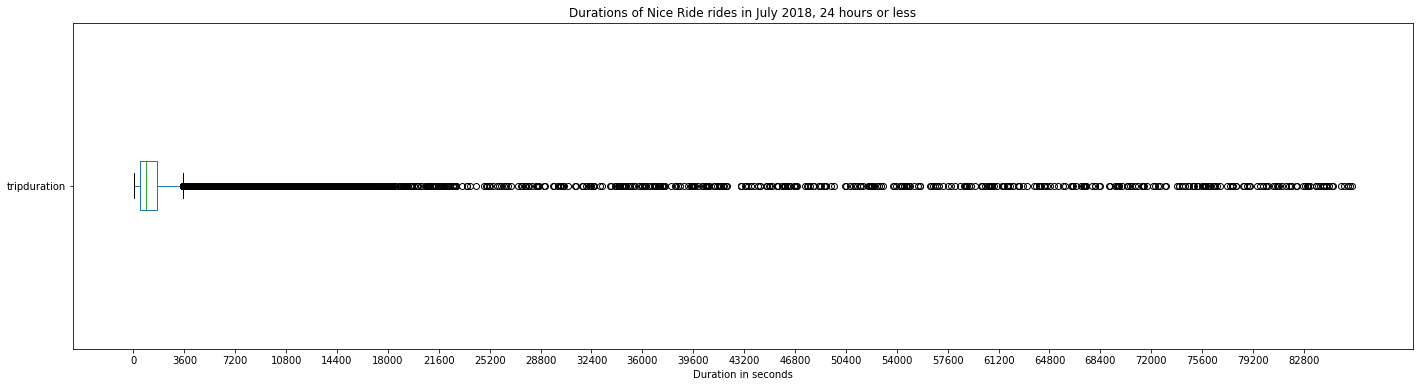

In [7]:
fig, ax_dur_box = plt.subplots(figsize=(24,6))

ax_dur_box = df_one_day_duration['tripduration'].plot.box(vert=False)
ax_dur_box.set_title('Durations of Nice Ride rides in July 2018, 24 hours or less')
ax_dur_box.set_xlabel('Duration in seconds')
ax_dur_box.set_xticks(range(0,86400,3600))
ax_dur_box.set_ylabel('')
plt.show()

The distribution of trip duration looks like a Pareto curve. In this histogram, just the first 200 minutes' worth of data points are shown, to make the shape of the distribution curve more apparent.

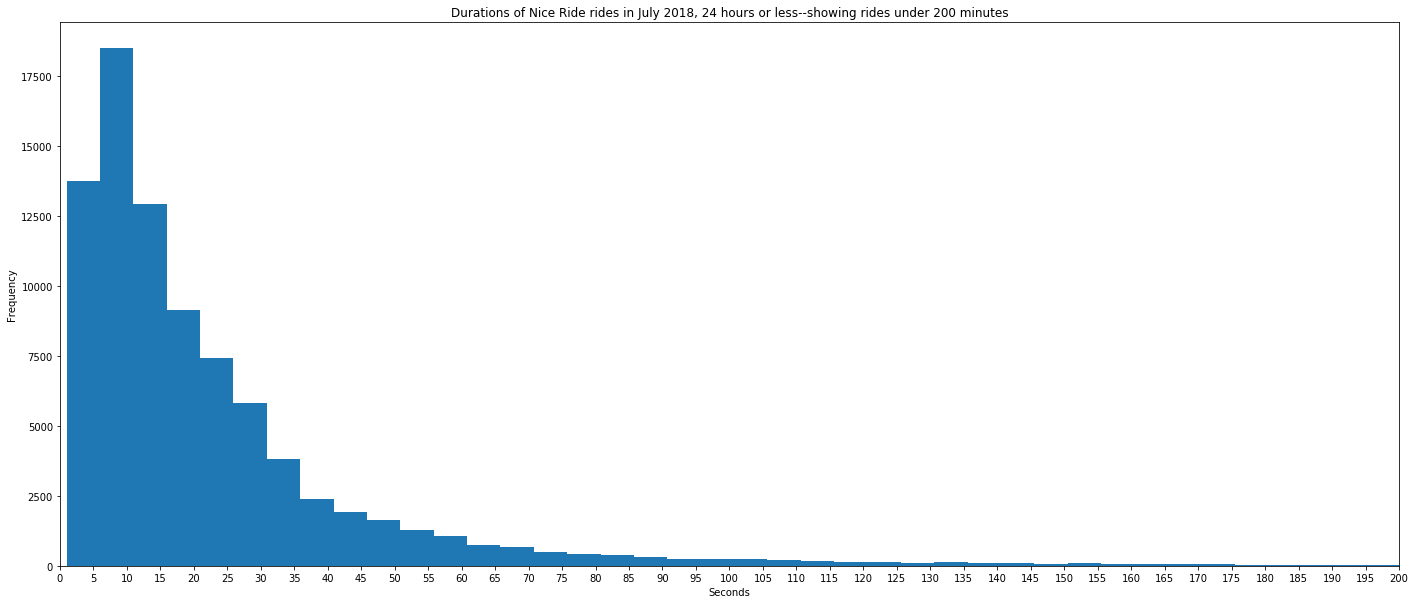

In [10]:
fig, ax_dur_hist = plt.subplots(figsize=(24,10))

# Plot a frequency of ride durations. 24 hours, 5-minute intervals = 288 bins
ax_dur_hist = df_one_day_duration['tripduration'].apply(lambda x: x / 60).plot.hist(bins=288)

ax_dur_hist.set_title('Durations of Nice Ride rides in July 2018, 24 hours or less--showing rides under 200 minutes')
ax_dur_hist.set_xlabel('Seconds')
ax_dur_hist.set_ylabel('Frequency')
ax_dur_hist.set_xticks(range(0,1440,5))
plt.xlim(0,200)
plt.show()

Single Nice Ride rentals are a flat fee for the first half hour, with additional charges accruing for every additional 30 minutes. Day pass purchasers can take unlimited 30-minute rides within 24 hours.

Subscribers to Nice Ride have access to bikes for unlimited periods of 60 minutes, for no additional charge.

Given this information, it is not surprising that the overwhelming majority of rides are under 60 minutes (3600 seconds), with the mean just under 28 minutes (1678 seconds).

## Who is the typical Nice Ride rider?

__No uniquely identifying rider data is included in this set, so the statistics in this section are all based on reported values from each trip taken in July 2018.__

### Customer vs. Subscriber

Over 70% of Nice Ride trips in July 2018 were taken by riders who purchased single-ride or single-day rentals--in the data, these rides have a user type of "Customer". Trips taken by Nice Ride subscribers make up the remainder.

This data isn't super interesting in itself, but the distinction between customers and subscribers becomes more important when looking at other rider-related fields, like gender and age--subscribers' ages and genders are consistently populated, while customers' information is not.

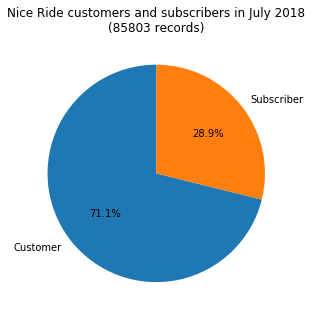

In [16]:
fig, ax_c_vs_s = plt.subplots(figsize=(15,5))

ax_c_vs_s.pie(df_one_day_duration['usertype'].value_counts(),
                       labels=['Customer','Subscriber'],
                       autopct='%1.1f%%',startangle=90)

ax_c_vs_s.set_title('Nice Ride customers and subscribers in July 2018\n({} records)'\
                             .format(df_one_day_duration['usertype'].count()))

plt.show()

### Rider gender

Nice Ride has gender and age information about their subscribers, and riders who use the Nice Ride app.


__For riders where gender is known, women are just over $1/3$ of the total riders, and men are close to $2/3$.__

Remember that there is no way to uniquely identify a rider with the given data; these values represent the reported gender of a rider for each trip taken in July 2018.

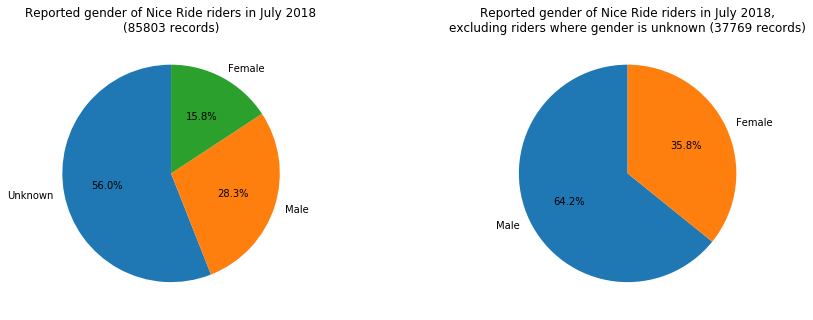

In [17]:
# Gender data
fig3, (ax_gender_all,ax_gender_filtered) = plt.subplots(1,2,figsize=(15,5))

ax_gender_all.pie(df_one_day_duration['gender'].value_counts(),
                  labels=['Unknown','Male','Female'],
                  autopct='%1.1f%%',startangle=90)

ax_gender_all.set_title('Reported gender of Nice Ride riders in July 2018\n({} records)'\
                        .format(df_one_day_duration['gender'].count()))

df_gender_filtered = df_one_day_duration.loc[(df_one_day_duration['gender'] != 0)]

ax_gender_filtered.pie(df_gender_filtered['gender'].value_counts(),
                       labels=['Male','Female'],
                       autopct='%1.1f%%',startangle=90)

ax_gender_filtered.set_title('Reported gender of Nice Ride riders in July 2018,\nexcluding riders where gender is unknown ({} records)'\
                             .format(df_gender_filtered['gender'].count()))

plt.show()

### Rider age

Birth year is consistently populated, even for trips where gender, another rider-related field, is unknown.

I noticed that around 40,000 records where gender is unknown have a birth year of 1969--it seems that combination of values represents a rider for whom both gender and birth year are not known. 

__To make more sense of the birth year data, I dropped records with a birth year of 1969 and a gender of Unknown__. 

I checked the frequencies of the User Type field before and after applying this filter to confirm that customer records were filtered more often than subscriber records, and found this to be overwhelmingly true. The filter only removed 49 Subscriber records, and over 40,000 Customer records. 

As with gender above, there is no way to uniquely identify a Nice Ride rider with the given data. These values represent the reported birth year of a rider for each trip in July 2018.

In [18]:
# The breakdown of customer vs. subscriber in the 24-hour filtered data
df_one_day_duration['usertype'].value_counts()

Customer      61029
Subscriber    24774
Name: usertype, dtype: int64

In [19]:
# There are around 40,000+ entries with birth year==1969.
# This seems to be a default value because it appears most frequently when gender==0.
# Let's filter out these rows.
df_filtered_age = df_one_day_duration.loc[~((df_one_day_duration['birth year'] == 1969) & \
                                            (df_one_day_duration['gender'] == 0))]

# Customer vs. subscriber counts after filtering gender==Unknown & birth year==1969.
df_filtered_age['usertype'].value_counts()

Subscriber    24725
Customer      19762
Name: usertype, dtype: int64

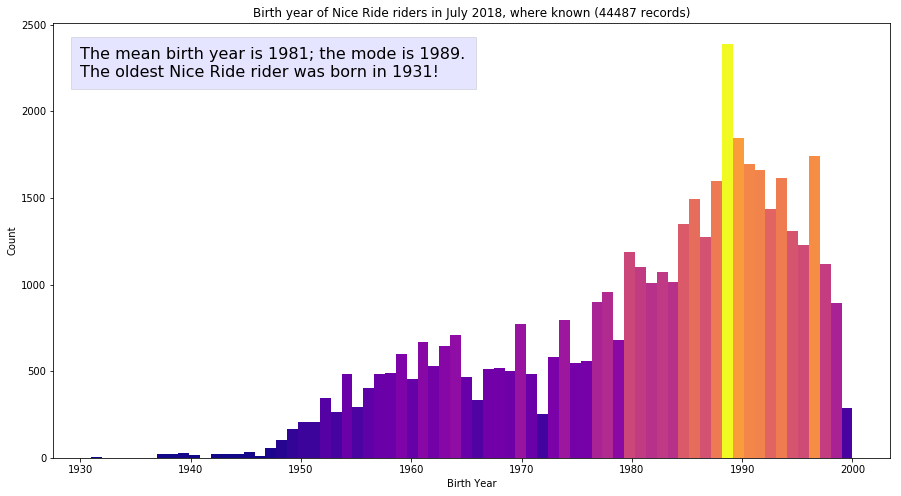

In [20]:
# Birth year data
fig2, ax_age = plt.subplots(figsize=(15,8))

# I eyeballed the data and saw a 70-year span.
N, bins, patches = ax_age.hist(df_filtered_age['birth year'],70)

# fracs is an array with a value between 0 and 1 for each bar of the histogram,
#  that is used to choose a color from the colormap
fracs = N.astype(float) / N.max()
norm = colors.Normalize(fracs.min(),fracs.max())

for thisfrac, thispatch in zip(fracs,patches):
    color = plt.cm.plasma(norm(thisfrac))
    thispatch.set_facecolor(color)
ax_age.set_xlabel('Birth Year')
ax_age.set_ylabel('Count')
ax_age.set_title('Birth year of Nice Ride riders in July 2018, where known ({} records)'\
                 .format(df_filtered_age['birth year'].count()))
ax_age.text(1930, 2200, "The mean birth year is {:.0f}; the mode is {}.\nThe oldest Nice Ride rider was born in {}!"\
            .format(df_filtered_age['birth year'].mean(),
                    df_filtered_age['birth year'].mode()[0],
                    df_filtered_age['birth year'].min()
                   ),
            fontsize=16,bbox={'facecolor':'blue', 'alpha':0.1, 'pad':10})
plt.show()

Out of sheer curiosity, I looked at the records in the data set where the birth year is 1931. There are four short customer trips around the downtown area in July, all under a half hour, in the middle of the day. I hope I'm still riding a bike when I'm in my late 80s!

## Further research:

* My analysis examined overall trip numbers and durations, but did not take time of day, or day of the week, into account. It would be interesting to summarize ride data in these two ways, to see the (assumed) periodicity of morning and evening commutes, or to compare weekday trips to trips taken on weekends. Are there quiet parts of the day where Nice Ride could offer some kind of incentives to encourage ridership? 
* I am interested in not just start and end points, but how they connect. Nice Ride bikes' locations during trips aren't a part of their public data, so specific routes can't be determined--but for the trips where the start and end points aren't the same, what does that flow of trips look like when plotted on a map? Again, this could be broken down by time of day or day of the week (an animation demonstrating this migration of riders over a period of time would be pretty cool). This could help determine future station placement, or show where "balancing" bikes could help Nice Ride ensure that bikes are available where and when riders want them.
* Nice Ride has a full nine seasons of data at this point. Assuming stations are placed in consistent locations from season to season, it could be useful to use historical data to forecast where and when lots of bike trips will occur, so bikes can be stocked at those locations. For example, there are a few large events in July that I presume would have caused spikes in ridership: Independence Day, Aquatennial, and the Basilica Block Party, to name three.
* Trip duration could also be divided based on single-use or daily "Customer" rides, versus "Subscriber" rides. For example, subscribers are allowed to ride a bike for twice as long as a customer before incremental charges are applied--are they taking advantage of this?
* Without more data regarding age and gender, it is harder to make confident decisions--but if the gender data Nice Ride collected is representative of Nice Ride users in general, and Nice Ride is interested in increasing ridership, they may want to tailor some marketing campaigns to appeal to women specifically. Looking at more data may help answer this question--if we are seeing the same reported percentages for gender over time, it's more likely that the split is representative.
